In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
import os
import json

# options to make text editable in illustrator
plt.style.use("stylesheet.mplstyle")
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

In [25]:
# Function to calculate confidence intervals
def get_ci(a):
    return sms.DescrStatsW(a).tconfint_mean()


# homophily in the original data is from 0 to 0.9. We need to rescale so homophily is between -1 and 1,
def rescale(values):
    return values * 2 - 1

## Define subplot names and metric names

In [26]:
# import metrics, metric_names, and exp_to_y_ax_labels from a global definition
metrics = json.load(open("definitions.json"))["metrics"]
metric_names = json.load(open("definitions.json"))["metric_names"]
exp_to_y_ax_labels = json.load(open("definitions.json"))["exp_to_y_axis_names"]
ax_labels = json.load(open("definitions.json"))["ax_labels"]
conditions = json.load(open("definitions.json"))["conditions"]
condition_names = json.load(open("definitions.json"))["condition_names"]

## Read suppression data

### take a look to make sure everything looks correct

In [27]:
result_dir = "multi_bad_actor_with_bias_bhvr_1"
helpfulness = "helpfulness_True"
df = pd.read_csv(f"{result_dir}/FP_count/{helpfulness}.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (7360, 15)


,params,run_result_dir,n_H,n_U,n_h,n_u,p_u_H,p_h_U,p_H_u,p_U_h,condition,n_uH,n_hU,no_run,st_prop
0,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,2019,7984,2599,7404,0.288262,0.447095,0.078606,0.145541,fn>=0,582.0,1162.0,1.0,0.0
1,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,4272,15728,5198,14802,0.322331,0.443055,0.093028,0.146427,all,1377.0,2303.0,1.0,0.0
2,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,3565,9034,4793,7806,0.244320,0.437930,0.111581,0.232344,fn<0_inferred,871.0,2099.0,1.0,0.0
3,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,707,6694,405,6996,0.715700,0.503704,0.072327,0.030475,fn>=0_inferred,506.0,204.0,1.0,0.0
4,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,2253,7744,2599,7398,0.352863,0.439015,0.107461,0.147340,fn<0,795.0,1141.0,1.0,0.0


In [28]:
# Read & prepare data
data = {}
data_summary = {}
df = pd.read_csv(f"{result_dir}/FP_count/{helpfulness}.csv")
df["st_prop"] = df["st_prop"] * 100
# df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
# df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
data[helpfulness] = df
for condition in conditions:
    print(f" ** {condition} **")
    focal = df[df["condition"] == condition].copy()
    print(" shape", df.shape)
    df = df.drop_duplicates(subset=["condition", "params"])
    print(" shape after dropping duplicates", df.shape)
    # Group by y values, compute mean and CI for each metric
    agg_funcs = {"params": ("params", "count")}
    for m in metrics:
        agg_funcs["condition"] = ("condition", "first")
        agg_funcs[m + "_mean"] = (m, "mean")
        agg_funcs[m + "_ci_lower"] = (m, lambda x: get_ci(x.values)[0])
        agg_funcs[m + "_ci_upper"] = (m, lambda x: get_ci(x.values)[1])

    df_summary = focal.groupby("st_prop").agg(**agg_funcs).reset_index()
    df_summary = df_summary.rename(columns={"params": "no_observations"})
    # Sanity check
    print(
        "  * Unique y values: ",
        [float(f"{x:.2f}") for x in df_summary["st_prop"].unique()],
    )
    print(
        f"    No. observations per y value: {df_summary['no_observations'].describe()['mean']} pm {df_summary['no_observations'].describe()['std']}"
    )
    print(f"    Available columns: {df_summary.columns.tolist()}\n")
    data_summary[f"{helpfulness}_{condition}"] = df_summary

 ** fn<0 **
 shape (7360, 15)
 shape after dropping duplicates (7360, 15)
  * Unique y values:  [0.0, 1.67, 3.33, 5.0, 6.67, 8.33, 10.0, 11.67, 13.33, 15.0, 16.67, 18.33, 20.0, 21.67, 23.33, 25.0]
    No. observations per y value: 92.0 pm 2.0
    Available columns: ['st_prop', 'no_observations', 'condition', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lower', 'p_U_h_ci_upper']

 ** fn>=0 **
 shape (7360, 15)
 shape after dropping duplicates (7360, 15)
  * Unique y values:  [0.0, 1.67, 3.33, 5.0, 6.67, 8.33, 10.0, 11.67, 13.33, 15.0, 16.67, 18.33, 20.0, 21.67, 23.33, 25.0]
    No. observations per y value: 92.0 pm 2.0
    Available columns: ['st_prop', 'no_observations', 'condition', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lowe

## Plot 2 panels (cross section fn<0 and fn>0)

In [29]:
def format_integer_ticks(x, pos):
    if round(x, 2) in (0, 1, -1):
        return str(int(round(x)))
    else:
        return f"{x:.1f}"

In [30]:
data_summary.keys()

dict_keys(['helpfulness_True_fn<0', 'helpfulness_True_fn>=0'])

fn<0 - p_h_U - mean: 0.51991344829991
fn>=0 - p_h_U - mean: 0.5211243429429098
fn<0 - p_u_H - mean: 0.42528506403643607
fn>=0 - p_u_H - mean: 0.4243440481971002


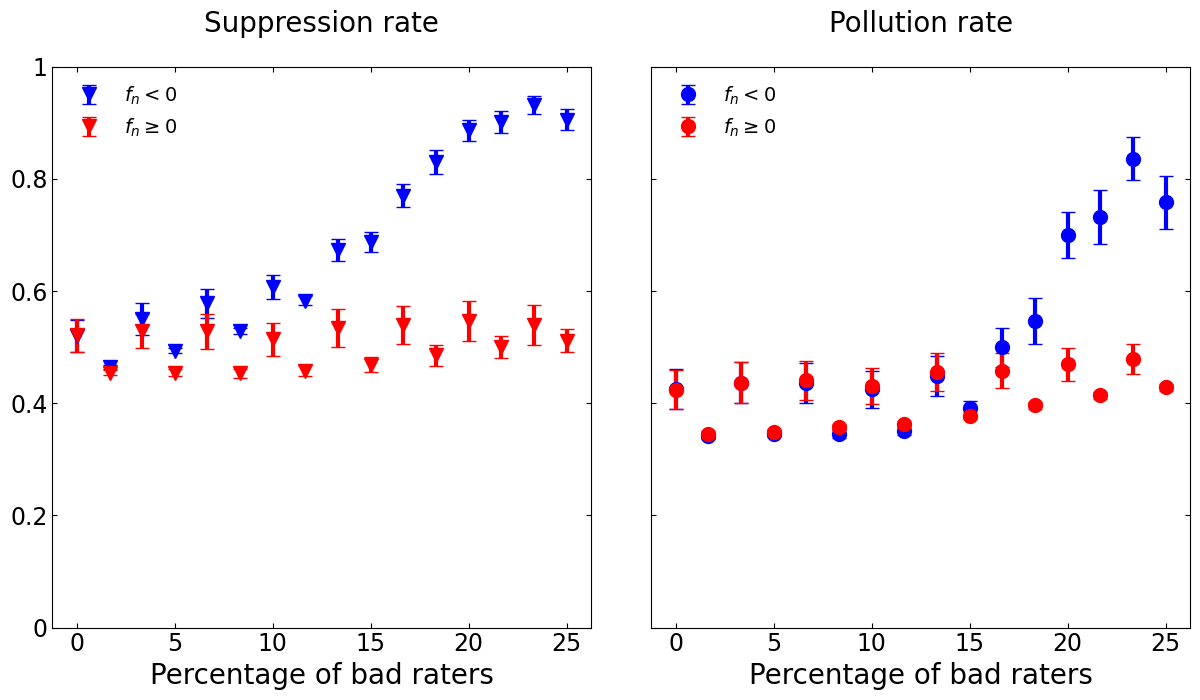

In [ ]:
FIG_NAME = "Fig3."
colors = {
    "fn<0": "blue",
    "fn>=0": "red",
}

helpfulness = "helpfulness_True"

# We only need 2 panels now: suppression + pollution
metrics_to_plot = ["p_h_U", "p_u_H"]
n_rows = 1
n_cols = len(metrics_to_plot)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(6 * n_cols, 7 * n_rows),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)


# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,
    h_pad=0.1,
    wspace=0.1,
    hspace=0.1,
)

for col, metric in enumerate(metrics_to_plot):
    ax = axes[col]

    # Loop over fn conditions: <0 (blue) and >=0 (red)
    for condition in conditions:  # assuming conditions = ["fn_neg", "fn_pos"]
        key = f"{helpfulness}_{condition}"
        if key not in data_summary:
            print(f"Key {key} not in data")
            continue
        df_summary = data_summary[key]

        x = df_summary["st_prop"]
        y_mean = df_summary[f"{metric}_mean"]
        y_lower = df_summary[f"{metric}_ci_lower"]
        y_upper = df_summary[f"{metric}_ci_upper"]
        yerr = [y_mean - y_lower, y_upper - y_mean]

        print(f"{condition} - {metric} - mean: {y_mean.values[0]}")
        # Choose marker based on metric
        marker = "v" if metric == "p_h_U" else "o"

        ax.errorbar(
            x,
            y_mean,
            yerr=yerr,
            fmt=marker,
            markersize=10,
            capsize=5,
            color=colors[condition],
            label=f"{condition_names[condition]}",
        )

    ax.tick_params(direction="in")
    ax.set_xlabel(ax_labels["st_prop"])

    import matplotlib.ticker as mticker

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))

    ax.legend(fontsize=14)

    ax.set_title(metric_names[metric], fontsize=20, pad=25)
    ax.set_ylim(0, 1)
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.top"] = True
# Current working directory (where notebook is running)
cwd = os.getcwd()
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# Save outputs
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.pdf", dpi=300, bbox_inches="tight")

plt.show()